## Cluster based on relative peak height

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler

# load data
wdir = '../../data'
df = pd.read_csv(os.path.join(wdir, 'processed/case_data.csv'))

# convert to date format
df['date'] = pd.to_datetime(df['year'].astype('str') + '-' + df['month'].astype('str') + '-' + '1')

# some extra string in place name
df['adm1'] = df['adm1'].str.strip()

# removing Chile, Norway, USA
df = df[~df['country'].isin(['USA', 'Chile', 'Norway'])]
#df = df[df['country'].isin(['Nigeria', 'China', 'Germany', 'Slovenia', 'France', 'Finland'])]


# calculate sum by month and fill in empty dates (where 0)
df = df.groupby(['disease', 'country', 'date']).sum('num_cases', min_count=1).reset_index()
df = df.set_index('date')
df = df.groupby(['disease', 'country']).resample('MS').asfreq(fill_value=0).drop(['country', 'disease'], axis=1).reset_index()
df['month'] = [date.month for date in df.date] # add in new months
df['year'] = [date.year for date in df.date] # and years

df.head()

,disease,country,date,year,month,num_cases
0,Bolivian Hemorrhagic Fever,Bolivia,2010-02-01,2010,2,1.0
1,Bolivian Hemorrhagic Fever,Bolivia,2010-03-01,2010,3,1.0
2,Bolivian Hemorrhagic Fever,Bolivia,2010-04-01,2010,4,0.0
3,Bolivian Hemorrhagic Fever,Bolivia,2010-05-01,2010,5,0.0
4,Bolivian Hemorrhagic Fever,Bolivia,2010-06-01,2010,6,0.0


### Calculate incidence

In [3]:
# using world bank data 
# load and reformat to long data
pop = pd.read_csv(wdir + '/human/worldbank_pop_counts.csv', skiprows=4)
# rename column
pop = pop.rename(columns={'Country Name': 'country'})
# rename slovakia
pop['country'] = pop['country'].str.replace('Slovak Republic', 'Slovakia')
# subset those in dataset
pop = pop[pop['country'].isin(df.country.unique())]
pop = pop.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)

pop = pop.melt(id_vars=['country'],
               var_name = 'year',
               value_name = 'population')

pop.year = pop.year.astype(int)
pop.head()

,country,year,population
0,Austria,1960,7047539.0
1,Bolivia,1960,3707515.0
2,Brazil,1960,73092515.0
3,China,1960,667070000.0
4,Germany,1960,72814900.0


In [4]:
# merge with case data and calcultate incidence
df = df.merge(pop, how='left', on=['country', 'year'])
df['incidence'] = df['num_cases']/df['population']*100000
df.head()

,disease,country,date,year,month,num_cases,population,incidence
0,Bolivian Hemorrhagic Fever,Bolivia,2010-02-01,2010,2,1.0,10223270.0,0.009782
1,Bolivian Hemorrhagic Fever,Bolivia,2010-03-01,2010,3,1.0,10223270.0,0.009782
2,Bolivian Hemorrhagic Fever,Bolivia,2010-04-01,2010,4,0.0,10223270.0,0.000000
3,Bolivian Hemorrhagic Fever,Bolivia,2010-05-01,2010,5,0.0,10223270.0,0.000000
4,Bolivian Hemorrhagic Fever,Bolivia,2010-06-01,2010,6,0.0,10223270.0,0.000000


In [5]:
# organize into list of series to work with
mySeries = [group for group in df.groupby(['country', 'disease'])]

# creae a names list
names = ['_'.join(series[0]) for series in mySeries]

len(mySeries)

12

Identifying peaks

In [57]:
def getCurves(ts):
    outbreak_ids = []
    
    mn = np.mean(ts.d)
    sd = np.std(ts.d)

    peaks, _ = find_peaks(ts.d, prominence=mn)
    
    fwd_i = 0
    bwd_i = 1

    for pk in peaks:

        # set current index number
        current_id = pk

        # move forward
        while ts.d[current_id] > ts.ma[current_id]:
            outbreak_ids.append(current_id)
            current_id += 1
            if current_id > len(ts.index)-1:
                break
        
        # move backward, starting from one behind
        current_id = pk - 1
        while ts.d[current_id] > ts.ma[current_id-1]:
            outbreak_ids.append(current_id)
            current_id -= 1
            if current_id < 0:
                break
    
    return(peaks, outbreak_ids)

In [ ]:
def getCurves(ts):
    outbreak_ids = []
    
    mn = np.mean(ts.d)
    sd = np.std(ts.d)

    peaks, _ = find_peaks(ts.d, prominence=mn)
    
    fwd_i = 0
    bwd_i = 1

    for pk in peaks:

        # set current index number
        current_id = pk

        # move forward
        while ts.d[current_id] > ts.ma[current_id]:
            outbreak_ids.append(current_id)
            current_id += 1
            if current_id > len(ts.index)-1:
                break
        
        # move backward, starting from one behind
        current_id = pk - 1
        while ts.d[current_id] > ts.ma[current_id-1]:
            outbreak_ids.append(current_id)
            current_id -= 1
            if current_id < 0:
                break
    
    return(peaks, outbreak_ids)

## 1. Grouping by peaks

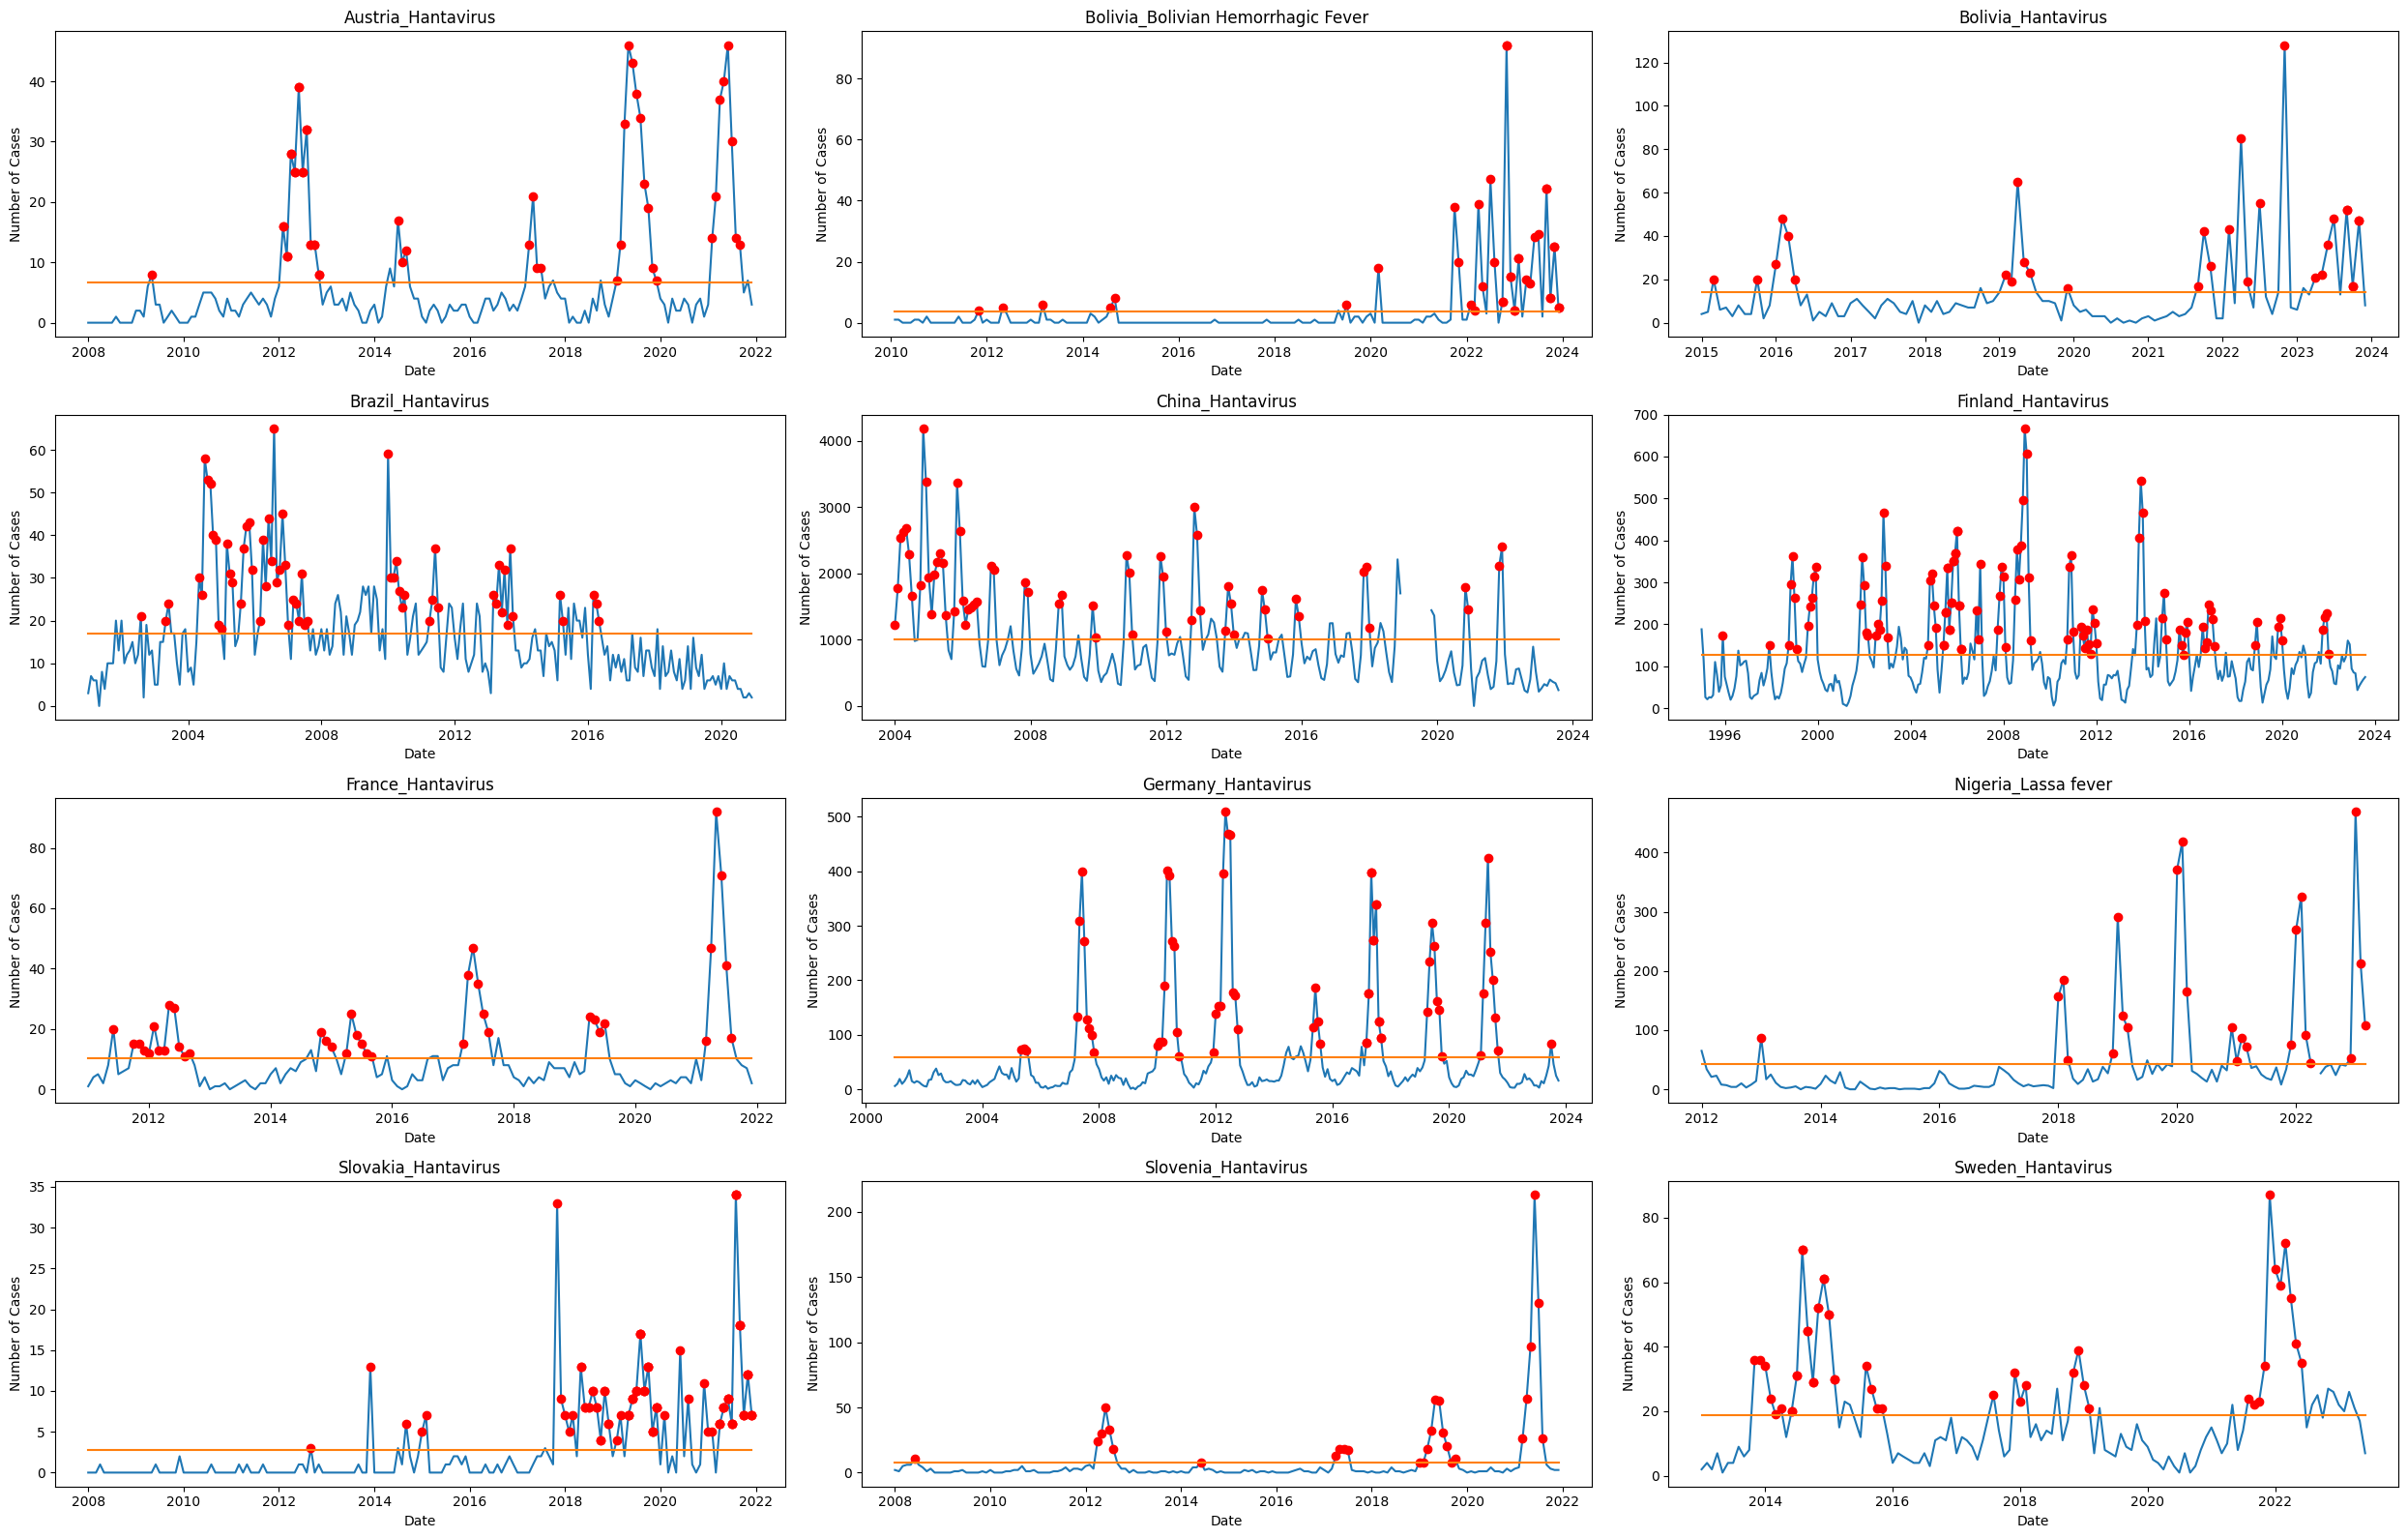

In [58]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import detrend
import math

# 15 disease/country combos so 3 x 5 plots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 16))

# flatten to easily iterate through
axs = axs.flatten()

# peak list
pks = []

df_list = []

# Iterate over the groups and plot on individual subplots
for i, series in enumerate(mySeries):
    series = series[1]
    series = series.set_index('date')
    #vals = scaler.fit_transform(series.num_cases.values.reshape(-1,1))
    #series['scaled_cases'] = vals
    #series['d'] = series['incidence'].diff()
    #series['d'] = series. detrend(series.num_cases, type='linear')
    #series['d'] = series['num_cases']
    
    # set first 12 months to first 12 month average
    #avg1 = df[df.date]
    #df['sa3'].fillna(df['s3'].mean(), inplace=True)

    
   # series['d'] = series['incidence']
   # series['d'] = scaler.fit_transform(series.d.values.reshape(-1,1))
    series['d'] = series['num_cases']
    series['ma'] = series['num_cases'].mean() #.rolling(window=24, min_periods=1).mean()
    #df['sa3'].fillna(df['s3'].mean(), inplace=True)
    
    mn = np.mean(series.d)
    sd = np.std(series.d)
    peaks, points = getCurves(series)

    # assign peak group
    series['peak_group'] = 0
    series.loc[series.index[points], 'peak_group'] = 1

    df_list.append(series)

    # plotting
    ax = axs[i]
    ax.plot(series.num_cases)
    ax.plot(series.index[points], series.num_cases[points], "o", color="r")
    ax.plot(series.ma)
    #ax.axhline(y=mn+sd, color='r', linestyle='--')
    #ax.axhline(y=mn+2*sd, color='r', linestyle='--')
    #ax.axhline(y=mn, color='b', linestyle='--')
    #ax.set_ylim(0,3)
    ax.set_xlabel('Date')
    #ax.set_yscale("log")
    ax.set_ylabel('Number of Cases')
    ax.set_title(names[i])
    

plt.tight_layout()
plt.show()

In [50]:
df.tail()

,date,disease,country,year,month,num_cases,population,incidence,d,ma,peak_group
2261,2023-02-01,Hantavirus,Sweden,2023,2,20.0,NaN,NaN,NaN,0.187322,0
2262,2023-03-01,Hantavirus,Sweden,2023,3,26.0,NaN,NaN,NaN,0.187322,0
2263,2023-04-01,Hantavirus,Sweden,2023,4,21.0,NaN,NaN,NaN,0.187322,0
2264,2023-05-01,Hantavirus,Sweden,2023,5,17.0,NaN,NaN,NaN,0.187322,0
2265,2023-06-01,Hantavirus,Sweden,2023,6,7.0,NaN,NaN,NaN,0.187322,0


In [59]:
df = pd.concat(df_list)
df = df.reset_index()
df.to_csv('../../output/outbreak_groups_meanprom.csv')

Trying using binary discretizer

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

# calculate log cases
kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
series = mySeries[0][1]
series['log_cases'] = np.log(1 + series.incidence)
out = kb.fit_transform(series.log_cases.values.reshape(-1,1))

In [ ]:
series['group'] = out

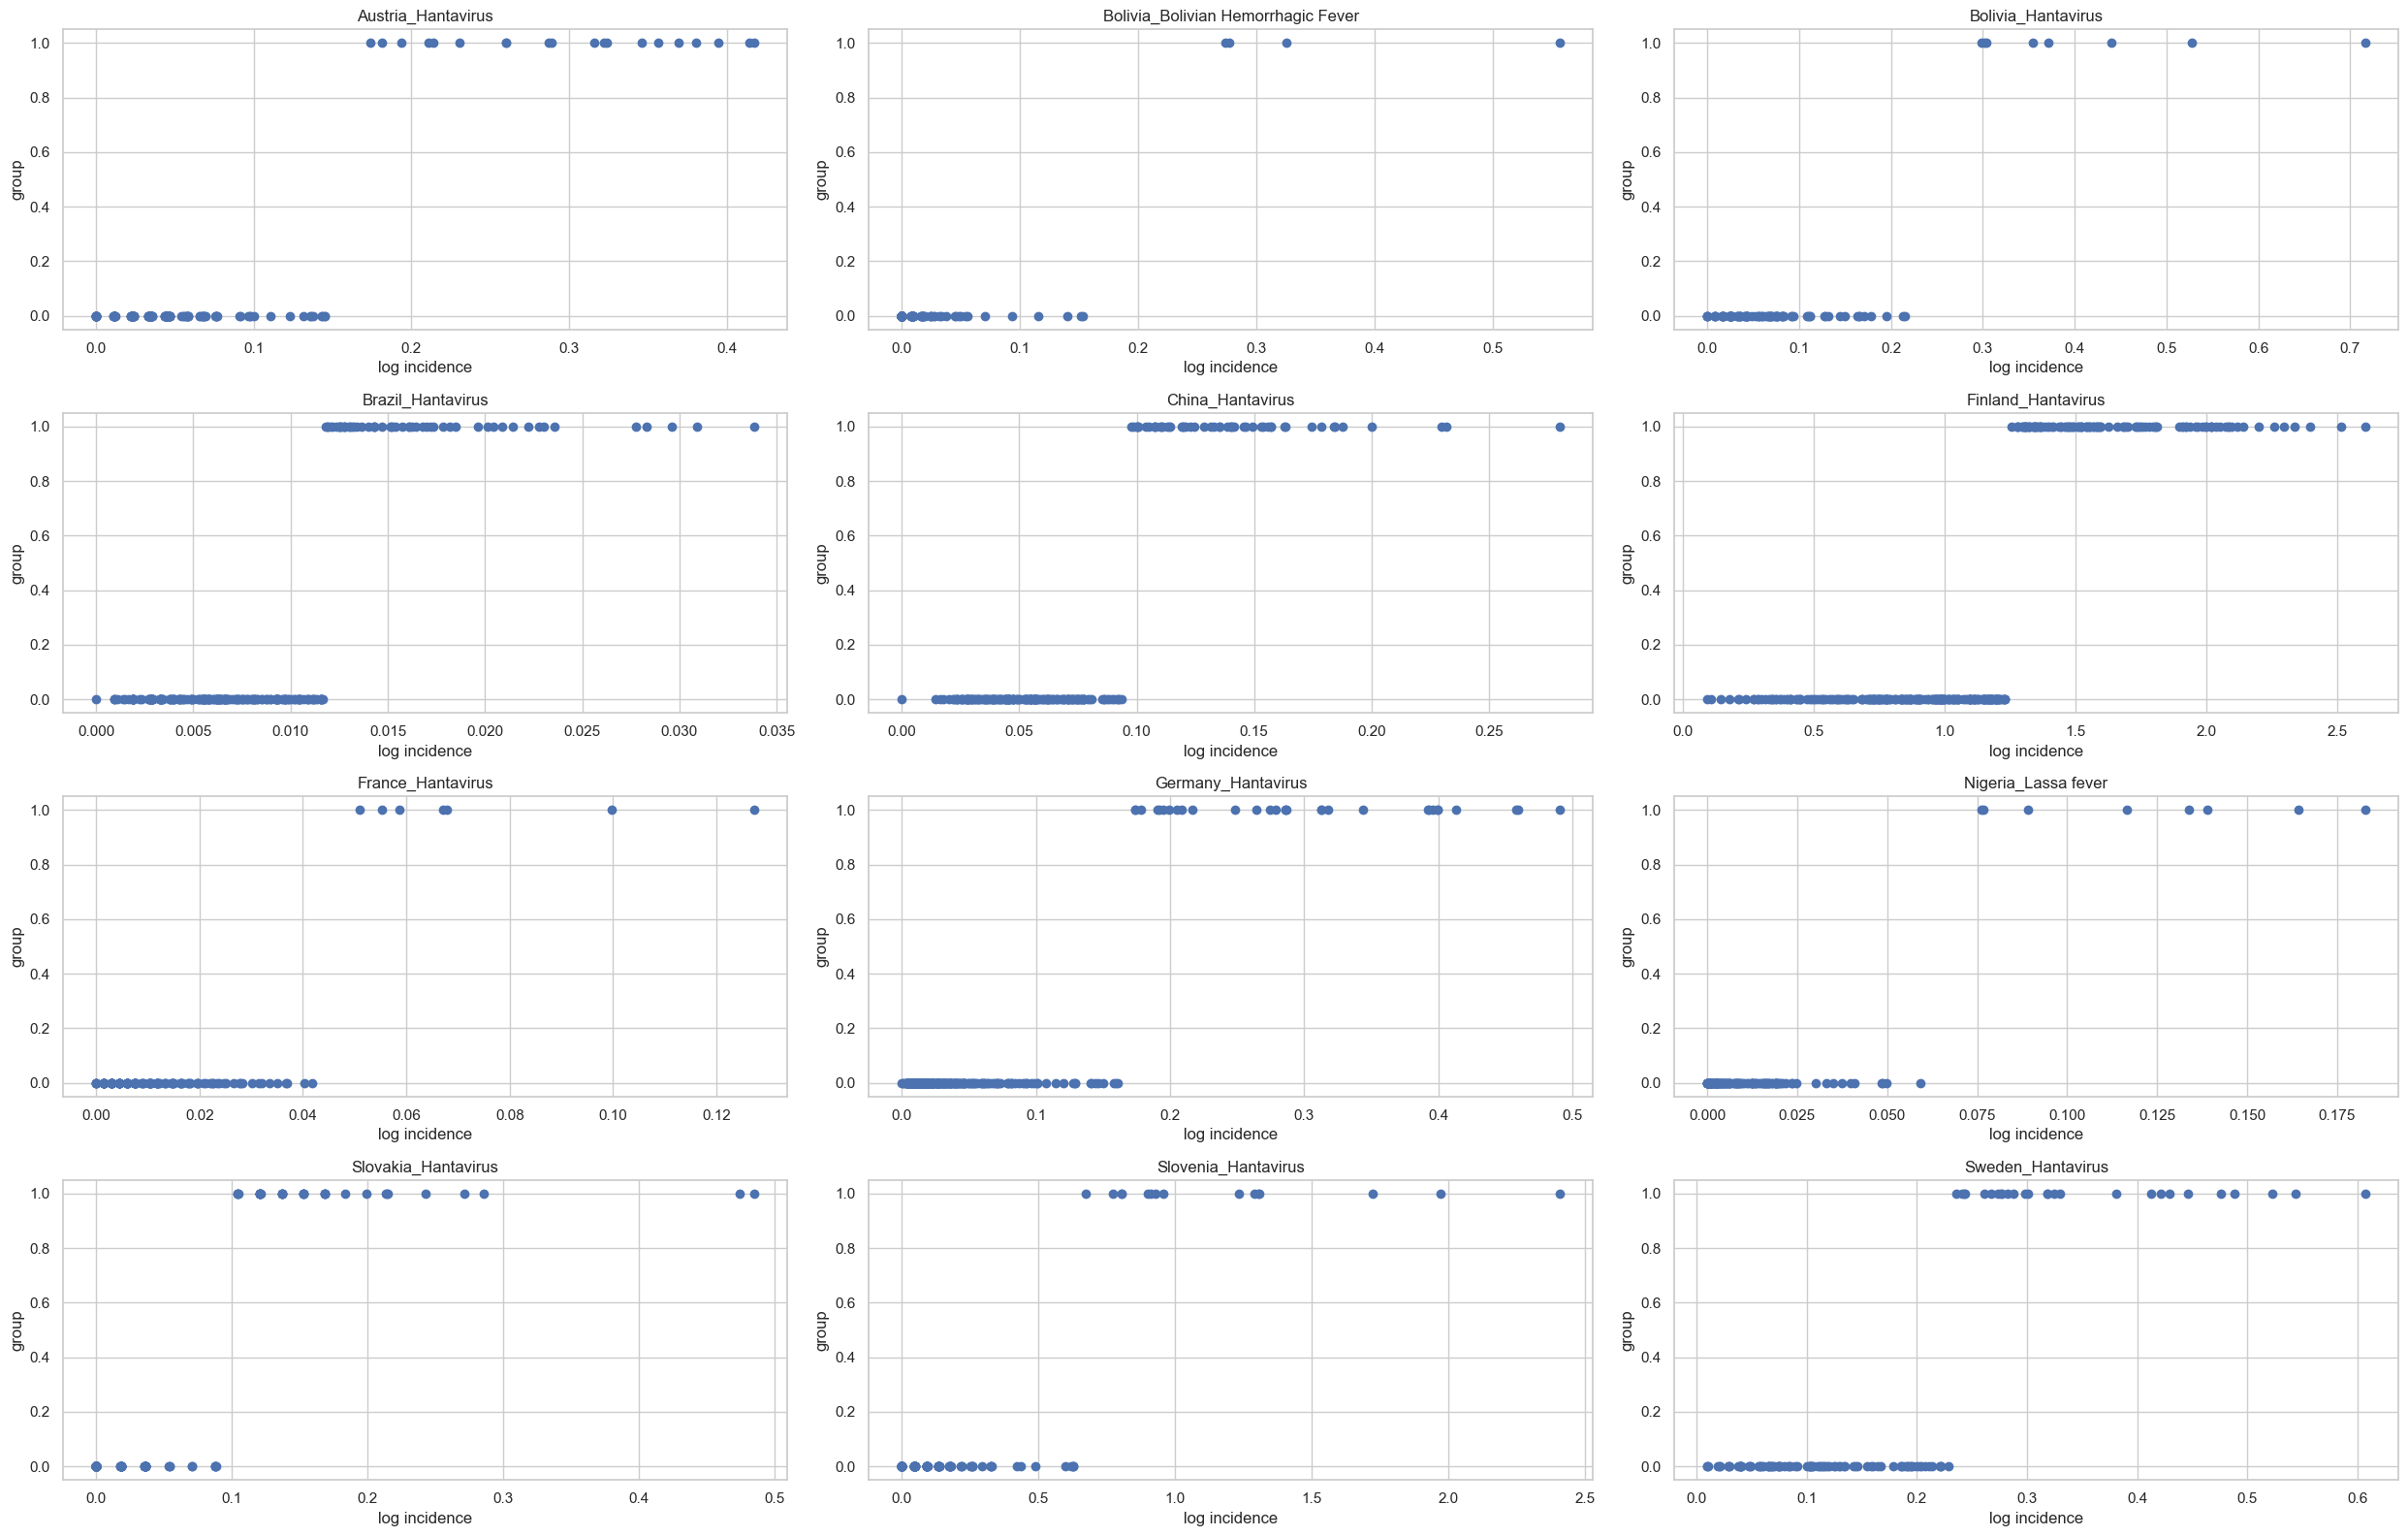

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import detrend
from sklearn.preprocessing import KBinsDiscretizer
import math

# 15 disease/country combos so 3 x 5 plots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 16))

# flatten to easily iterate through
axs = axs.flatten()

# create discretizer
kb = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')

df_list = []

# Iterate over the groups and plot on individual subplots
for i, series in enumerate(mySeries):
    series = series[1]
    series = series.set_index('date')
    #vals = scaler.fit_transform(series.log_cases.values.reshape(-1,1))
    #series['scaled_cases'] = vals
    
    # calculate log cases
    series['log_cases'] = np.log(1 + series.incidence)
    series = series.dropna()

    # separate into bins
    out = kb.fit_transform(series['log_cases'].values.reshape(-1,1))

    # assign peak group
    series['peak_group'] = out
    #series['peak_group'] = 0
    #series.loc[series.index[peaks1], 'peak_group'] = 1

    df_list.append(series)

    # plotting
    ax = axs[i]
    ax.plot(series.log_cases, series.peak_group, 'bo')
    ax.set_xlabel('log incidence')
    ax.set_ylabel('group')
    ax.set_title(names[i])
    

plt.tight_layout()
plt.show()

In [ ]:
df = pd.concat(df_list)
df = df.reset_index()
df.to_csv('../../output/outbreak_groups_v2.csv')

Create histogram of peak heights.

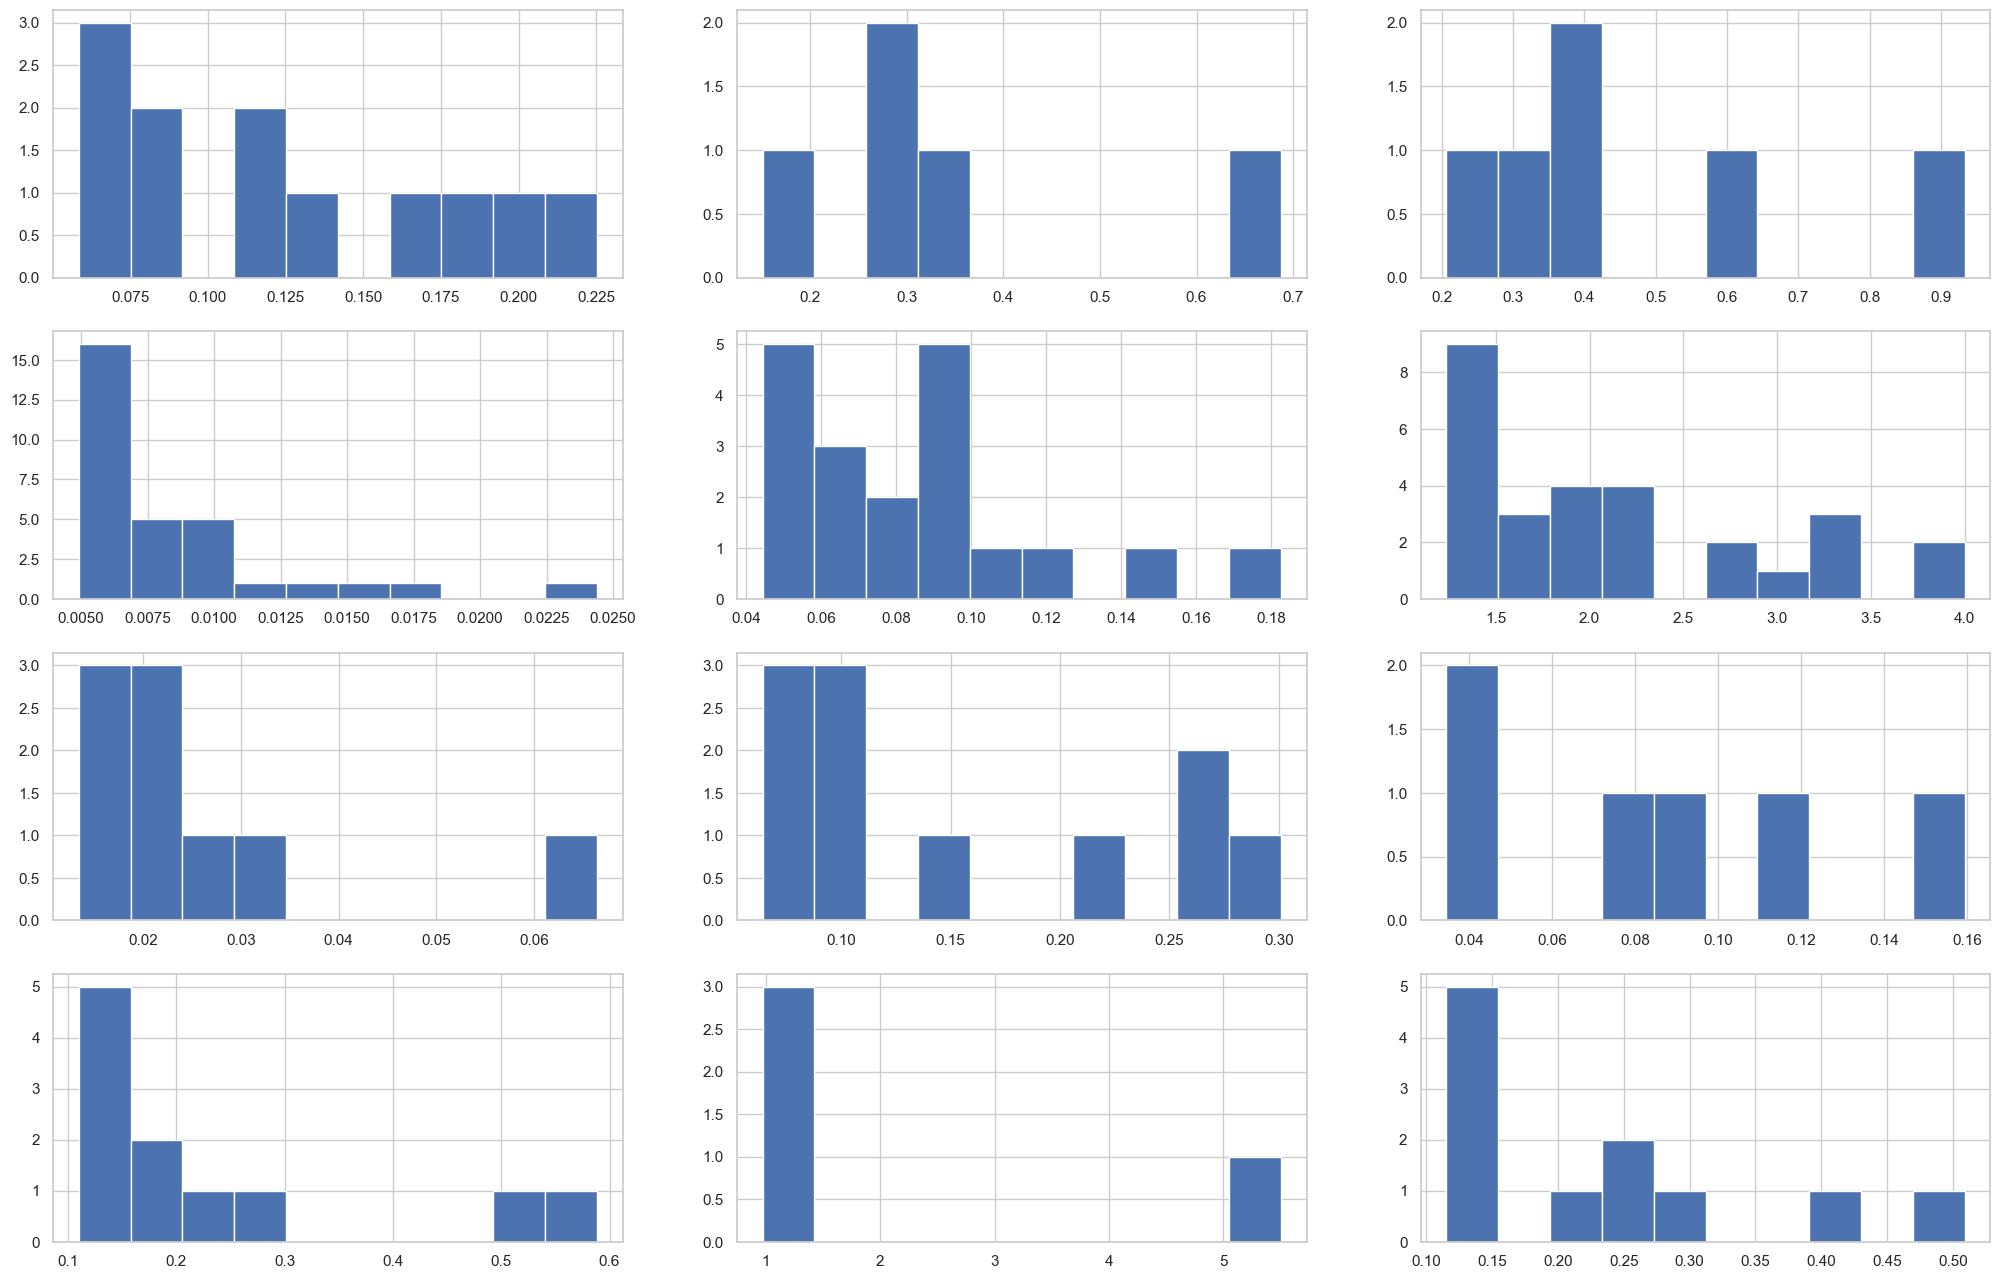

In [ ]:
# 15 disease/country combos so 3 x 5 plots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 16))

# flatten to easily iterate through
axs = axs.flatten()

for i, d in enumerate(pks):
    axs[i].hist(d);
    #axs[i].axvline(np.mean(d), linestyle='--', color='g')
    #axs[i].axvline(np.mean(d)+np.std(d), linestyle='--', color='r')
    #axs[i].axvline(np.mean(d)+2*np.std(d), linestyle='--', color='r')


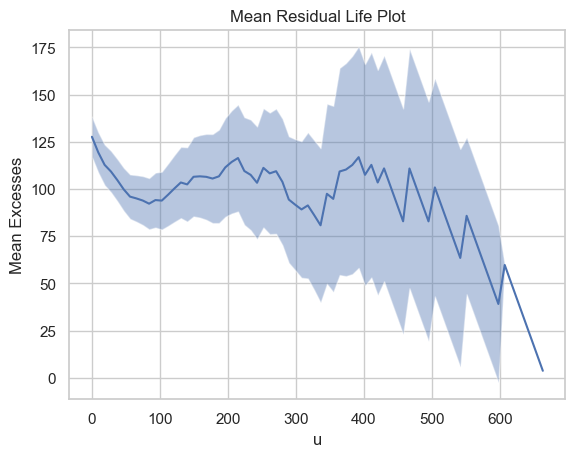

In [ ]:
from thresholdmodeling import thresh_modeling

thresh_modeling.MRL(mySeries[5][1].num_cases.values.ravel(), 0.05)
#thresh_modeling.Parameter_Stability_plot(mySeries[0][1].num_cases.values.ravel(), 0.05)

Estimator: MLE 
 Deviance: 1911.561 
      AIC: 1915.561 

Varying Threshold: FALSE 

  Threshold Call: 100L 
    Number Above: 172 
Proportion Above: 0.5 

Estimates
  scale    shape  
87.6790   0.0829  

Standard Error Type: observed 

Standard Errors
   scale     shape  
10.58263   0.09374  

Asymptotic Variance Covariance
       scale       shape     
scale  111.992076   -0.725129
shape   -0.725129    0.008787

Optimization Information
  Convergence: successful 
  Function Evaluations: 40 
  Gradient Evaluations: 21 




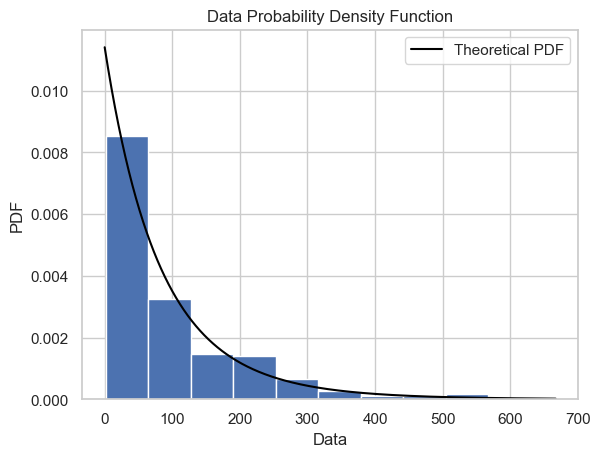

Estimator: MLE 
 Deviance: 1911.561 
      AIC: 1915.561 

Varying Threshold: FALSE 

  Threshold Call: 100L 
    Number Above: 172 
Proportion Above: 0.5 

Estimates
  scale    shape  
87.6790   0.0829  

Standard Error Type: observed 

Standard Errors
   scale     shape  
10.58263   0.09374  

Asymptotic Variance Covariance
       scale       shape     
scale  111.992076   -0.725129
shape   -0.725129    0.008787

Optimization Information
  Convergence: successful 
  Function Evaluations: 40 
  Gradient Evaluations: 21 




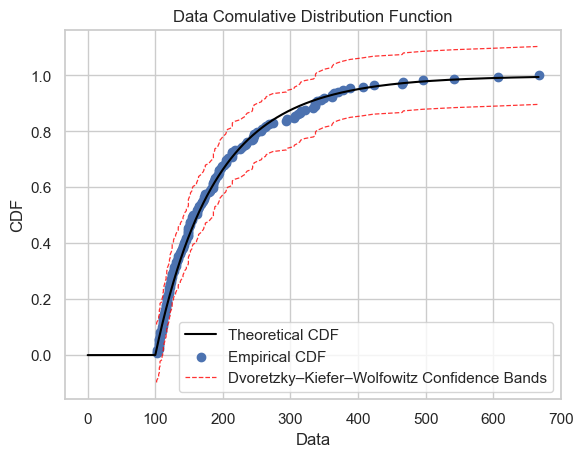

In [ ]:
thresh_modeling.gpdpdf(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 'sturges', 0.05)
thresh_modeling.gpdcdf(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 0.05)
#thresh_modeling.qqplot(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 0.05)
#thresh_modeling.ppplot(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 0.05)

In [ ]:
testcases = [d.scaled_cases for d in df_list]

In [ ]:
testcases = [x for xs in testcases for x in xs]

In [ ]:
p = [x for xs in pks for x in xs]

In [ ]:
x = np.array(range(100))

In [ ]:
dffull = dffull.reset_index()

/Users/natai/miniconda3/envs/rbdml/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/natai/miniconda3/envs/rbdml/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


<Axes: xlabel='Threshold', ylabel='Mean excess'>

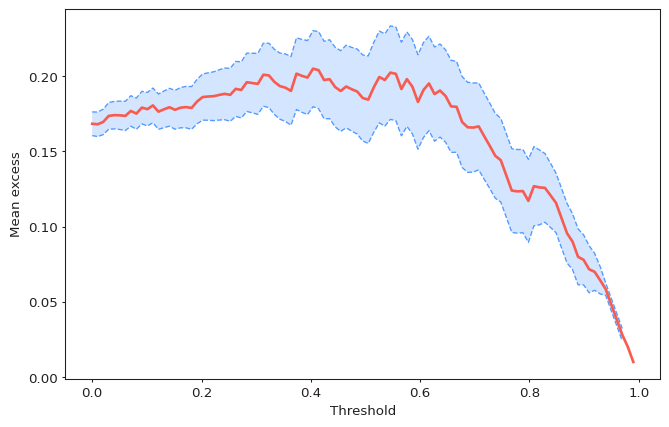

In [ ]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(dffull.scaled_cases, thresholds=np.array(np.linspace(0,1, 100)))

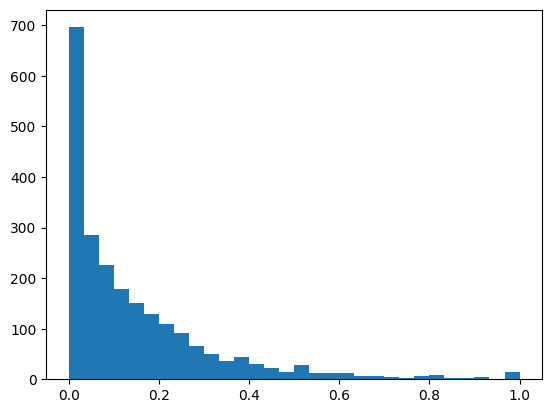

In [ ]:
plt.hist(dffull.scaled_cases, bins=30);

In [ ]:
np.std(p)

0.8287995886499298

In [ ]:
df = pd.concat(df_list)
df = df.reset_index()
df.to_csv('../../output/outbreak_groups_v2.csv')

In [ ]:
def check_series(testSet, length=12):
    ids  = [i for i, s in enumerate(testSet) if len(s) > length]
    if len(ids) > 1:
        print('Some series do not have '+ str(length) + ' points.')
        return(ids)
    else:
        print('Series good to go!')
        return

def get_color(label, colormap='tab10'):   
    cmap = plt.get_cmap(colormap)
    color = cmap(label % 10)
    return color

# function for calculating cdf
def cdf(s):
    s = s.sort_index()
    vals = s.num_cases.cumsum() / s.num_cases.sum()
    return(vals)

In [ ]:
from tslearn.barycenters import dtw_barycenter_averaging
import matplotlib.pyplot as plt


def plot_series(seriesList, group='year'):
    num_plots = len(seriesList)
    num_rows = (num_plots + 1) // 2 
    num_cols = min(3, num_plots) 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))
    axs = axs.flatten() 
    for i, series in enumerate(mySeries):
        series = series[1]
        ax = axs[i]
        ax.plot(series.scaled_cases)
        #ax.plot(series.index[peaks], series.num_cases[peaks], "x")
        #ax.set_ylim(0,3)
        ax.set_xlabel('Date')
        #ax.set_yscale("log")
        ax.set_ylabel('Disease incience (cases per 10,000 people)')
        ax.set_title(names[i])



# plotting functions
def plot_clusters(labels, input_data, avg='ba'):
    num_plots = len(set(labels))
    num_rows = (num_plots + 1) // 2  
    num_cols = min(2, num_plots) 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))
    axs = axs.flatten()

    row=0

    for label in set(labels):    
        cluster = []
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row].plot(input_data[i],c="gray",alpha=0.4)
                cluster.append(input_data[i])
        if len(cluster) > 0:
            if avg == 'ba':
                axs[row].plot(dtw_barycenter_averaging(np.vstack(cluster)),c=get_color(label), linewidth=5)
            if avg == 'euc':
                axs[row].plot(np.average(np.vstack(cluster),axis=0),c=get_color(label), linewidth=5)
        axs[row].set_title("Cluster "+str(label))
        axs[row].set_ylim(0,1)
        axs[row].set_xlim(0,12)
        row+=1
    
    plt.tight_layout()
    plt.show()

In [173]:
df = pd.concat(df_list)
df = df.reset_index()
df.to_csv('../../output/outbreak_groups_v2.csv')

Trying using binary discretizer

In [175]:
mySeries[0][1]

('Bolivia', 'Bolivian Hemorrhagic Fever')

In [197]:
from sklearn.preprocessing import KBinsDiscretizer

# calculate log cases
kb = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
series = mySeries[0][1]
series['log_cases'] = np.log(1 + series.incidence)
out = kb.fit_transform(series.log_cases.values.reshape(-1,1))

In [199]:
series['group'] = out

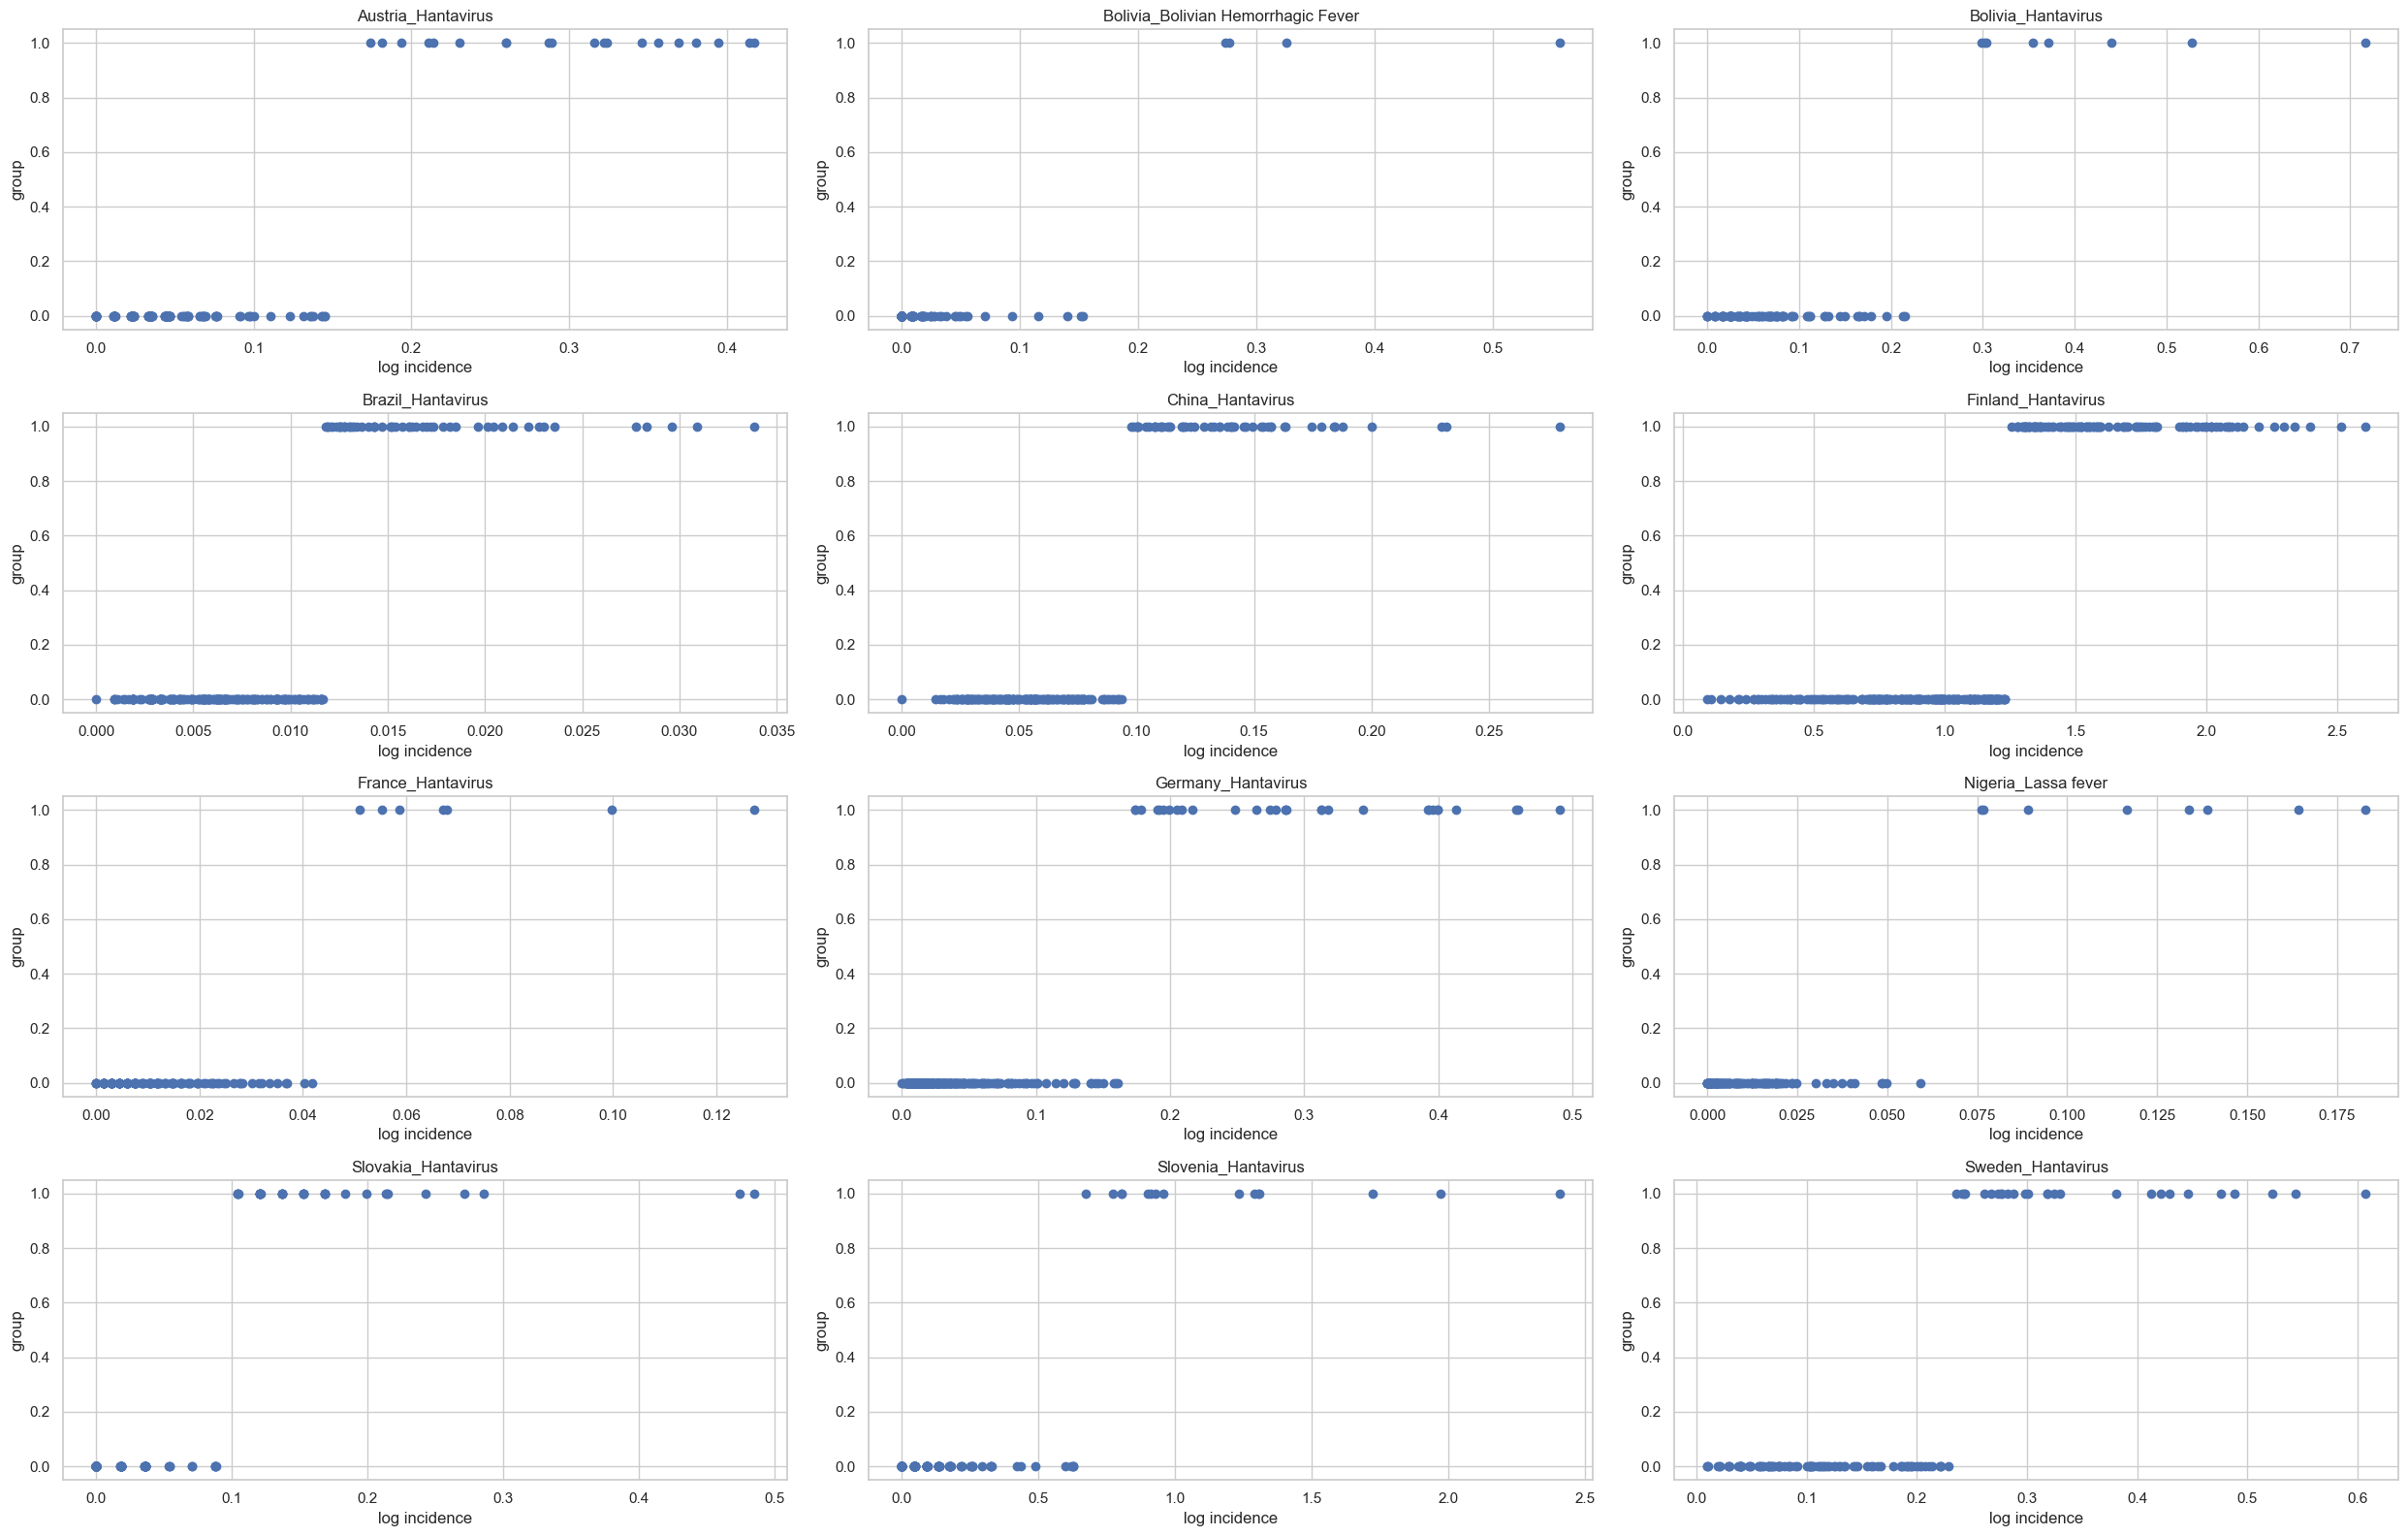

In [328]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import detrend
from sklearn.preprocessing import KBinsDiscretizer
import math

# 15 disease/country combos so 3 x 5 plots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 16))

# flatten to easily iterate through
axs = axs.flatten()

# create discretizer
kb = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')

df_list = []

# Iterate over the groups and plot on individual subplots
for i, series in enumerate(mySeries):
    series = series[1]
    series = series.set_index('date')
    #vals = scaler.fit_transform(series.log_cases.values.reshape(-1,1))
    #series['scaled_cases'] = vals
    
    # calculate log cases
    series['log_cases'] = np.log(1 + series.incidence)
    series = series.dropna()

    # separate into bins
    out = kb.fit_transform(series['log_cases'].values.reshape(-1,1))

    # assign peak group
    series['peak_group'] = out
    #series['peak_group'] = 0
    #series.loc[series.index[peaks1], 'peak_group'] = 1

    df_list.append(series)

    # plotting
    ax = axs[i]
    ax.plot(series.log_cases, series.peak_group, 'bo')
    ax.set_xlabel('log incidence')
    ax.set_ylabel('group')
    ax.set_title(names[i])
    

plt.tight_layout()
plt.show()

In [232]:
df = pd.concat(df_list)
df = df.reset_index()
df.to_csv('../../output/outbreak_groups_v2.csv')

Create histogram of peak heights.

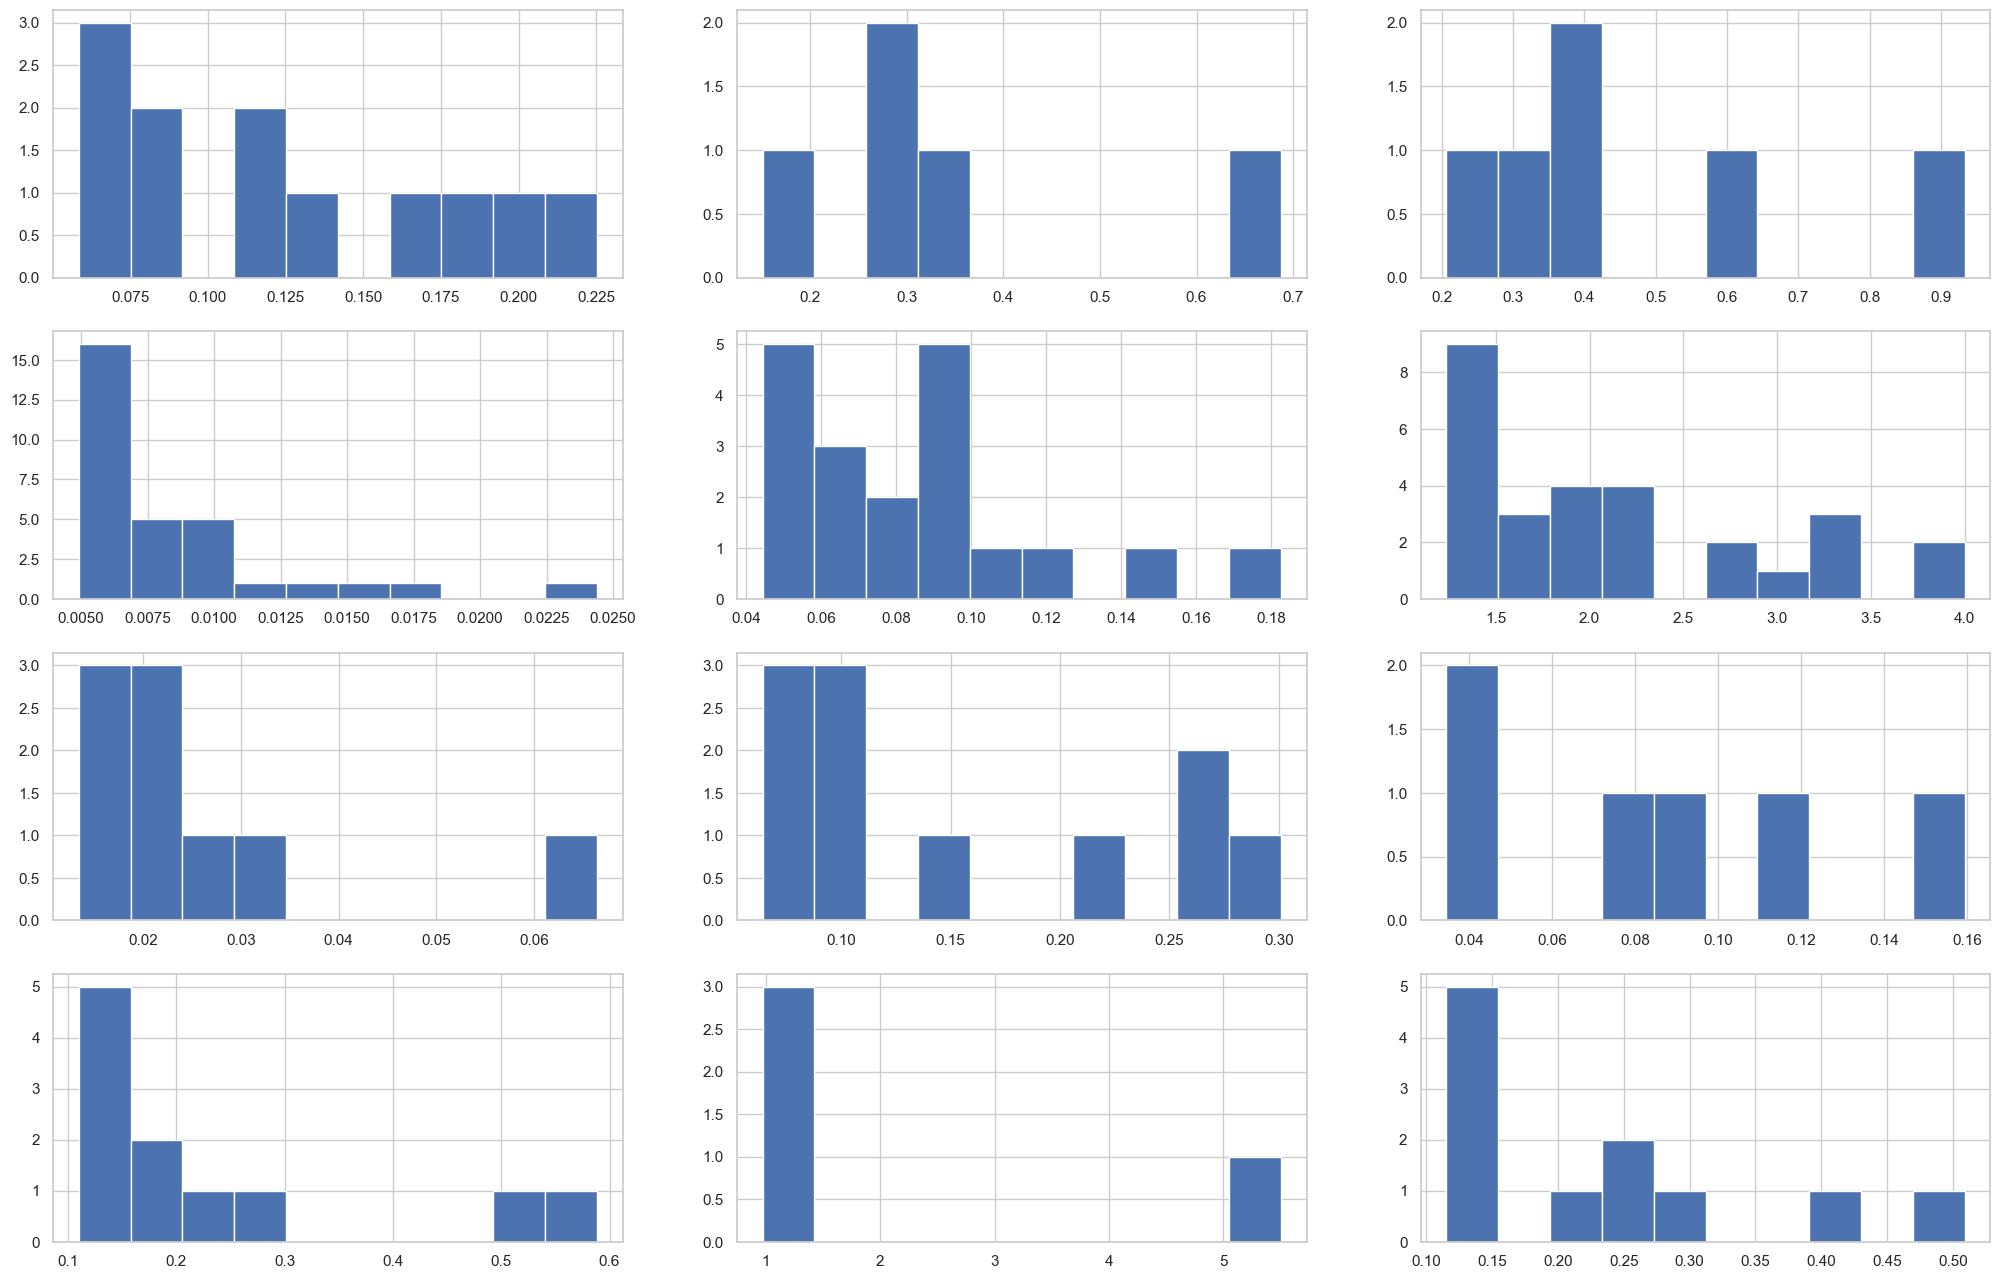

In [165]:
# 15 disease/country combos so 3 x 5 plots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(25, 16))

# flatten to easily iterate through
axs = axs.flatten()

for i, d in enumerate(pks):
    axs[i].hist(d);
    #axs[i].axvline(np.mean(d), linestyle='--', color='g')
    #axs[i].axvline(np.mean(d)+np.std(d), linestyle='--', color='r')
    #axs[i].axvline(np.mean(d)+2*np.std(d), linestyle='--', color='r')


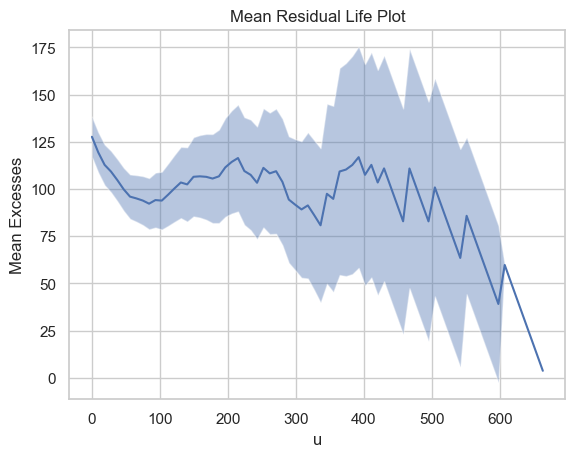

In [144]:
from thresholdmodeling import thresh_modeling

thresh_modeling.MRL(mySeries[5][1].num_cases.values.ravel(), 0.05)
#thresh_modeling.Parameter_Stability_plot(mySeries[0][1].num_cases.values.ravel(), 0.05)

Estimator: MLE 
 Deviance: 1911.561 
      AIC: 1915.561 

Varying Threshold: FALSE 

  Threshold Call: 100L 
    Number Above: 172 
Proportion Above: 0.5 

Estimates
  scale    shape  
87.6790   0.0829  

Standard Error Type: observed 

Standard Errors
   scale     shape  
10.58263   0.09374  

Asymptotic Variance Covariance
       scale       shape     
scale  111.992076   -0.725129
shape   -0.725129    0.008787

Optimization Information
  Convergence: successful 
  Function Evaluations: 40 
  Gradient Evaluations: 21 




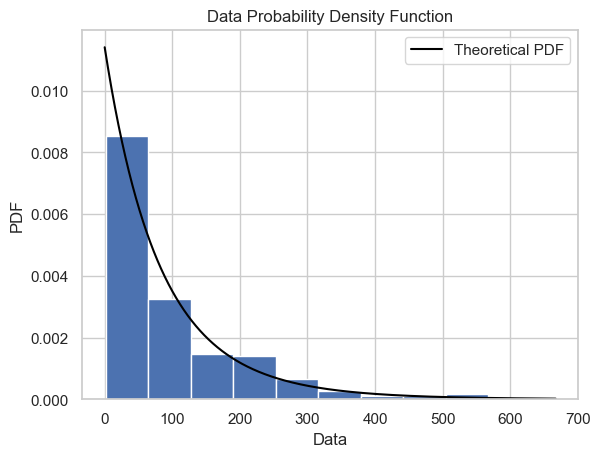

Estimator: MLE 
 Deviance: 1911.561 
      AIC: 1915.561 

Varying Threshold: FALSE 

  Threshold Call: 100L 
    Number Above: 172 
Proportion Above: 0.5 

Estimates
  scale    shape  
87.6790   0.0829  

Standard Error Type: observed 

Standard Errors
   scale     shape  
10.58263   0.09374  

Asymptotic Variance Covariance
       scale       shape     
scale  111.992076   -0.725129
shape   -0.725129    0.008787

Optimization Information
  Convergence: successful 
  Function Evaluations: 40 
  Gradient Evaluations: 21 




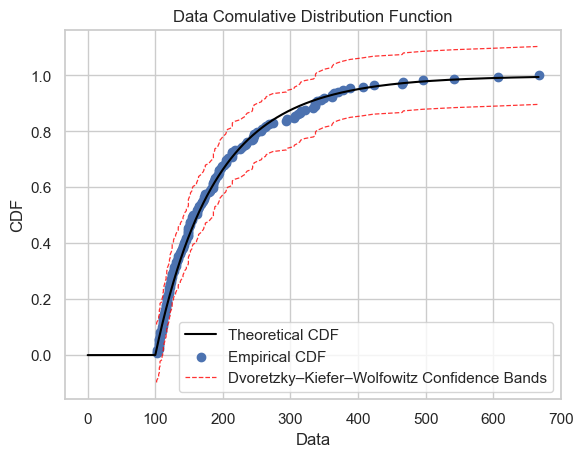

In [149]:
thresh_modeling.gpdpdf(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 'sturges', 0.05)
thresh_modeling.gpdcdf(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 0.05)
#thresh_modeling.qqplot(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 0.05)
#thresh_modeling.ppplot(mySeries[5][1].num_cases.values.ravel(), 100, 'mle', 0.05)

In [87]:
testcases = [d.scaled_cases for d in df_list]

In [88]:
testcases = [x for xs in testcases for x in xs]

In [55]:
p = [x for xs in pks for x in xs]

In [91]:
x = np.array(range(100))

In [107]:
dffull = dffull.reset_index()

/Users/natai/miniconda3/envs/rbdml/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/natai/miniconda3/envs/rbdml/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


<Axes: xlabel='Threshold', ylabel='Mean excess'>

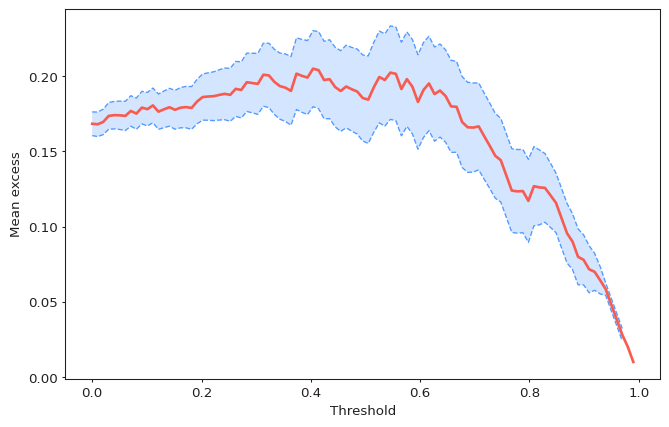

In [114]:
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(dffull.scaled_cases, thresholds=np.array(np.linspace(0,1, 100)))

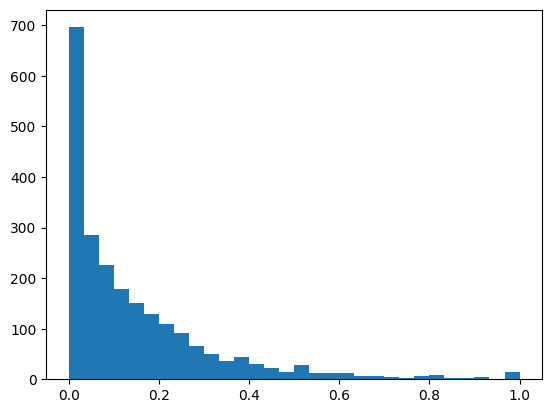

In [97]:
plt.hist(dffull.scaled_cases, bins=30);

In [43]:
np.std(p)

0.8287995886499298

In [171]:
df = pd.concat(df_list)
df = df.reset_index()
df.to_csv('../../output/outbreak_groups_v2.csv')

In [4]:
def check_series(testSet, length=12):
    ids  = [i for i, s in enumerate(testSet) if len(s) > length]
    if len(ids) > 1:
        print('Some series do not have '+ str(length) + ' points.')
        return(ids)
    else:
        print('Series good to go!')
        return

def get_color(label, colormap='tab10'):   
    cmap = plt.get_cmap(colormap)
    color = cmap(label % 10)
    return color

# function for calculating cdf
def cdf(s):
    s = s.sort_index()
    vals = s.num_cases.cumsum() / s.num_cases.sum()
    return(vals)

In [10]:
from tslearn.barycenters import dtw_barycenter_averaging
import matplotlib.pyplot as plt


def plot_series(seriesList, group='year'):
    num_plots = len(seriesList)
    num_rows = (num_plots + 1) // 2 
    num_cols = min(3, num_plots) 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))
    axs = axs.flatten() 
    for i, series in enumerate(mySeries):
        series = series[1]
        ax = axs[i]
        ax.plot(series.scaled_cases)
        #ax.plot(series.index[peaks], series.num_cases[peaks], "x")
        #ax.set_ylim(0,3)
        ax.set_xlabel('Date')
        #ax.set_yscale("log")
        ax.set_ylabel('Disease incience (cases per 10,000 people)')
        ax.set_title(names[i])



# plotting functions
def plot_clusters(labels, input_data, avg='ba'):
    num_plots = len(set(labels))
    num_rows = (num_plots + 1) // 2  
    num_cols = min(2, num_plots) 
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))
    axs = axs.flatten()

    row=0

    for label in set(labels):    
        cluster = []
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row].plot(input_data[i],c="gray",alpha=0.4)
                cluster.append(input_data[i])
        if len(cluster) > 0:
            if avg == 'ba':
                axs[row].plot(dtw_barycenter_averaging(np.vstack(cluster)),c=get_color(label), linewidth=5)
            if avg == 'euc':
                axs[row].plot(np.average(np.vstack(cluster),axis=0),c=get_color(label), linewidth=5)
        axs[row].set_title("Cluster "+str(label))
        axs[row].set_ylim(0,1)
        axs[row].set_xlim(0,12)
        row+=1
    
    plt.tight_layout()
    plt.show()